Tập dữ liệu có khoảng 852 ảnh cùng với một tệp chứa thông tin dán nhãn. Mỗi bức ảnh có thể chứa nhiều hơn một người, folder annotations chứa những thông tin về image, tọa độ của mỗi gương mặt. Tập dât gồm đeo khẩu trang, không đeo khẩu trang, đeo khẩu trang, đeo khẩu trang sai cách.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # image plotting
import os

Input đầu vào gồm 2 folder chính: Tệp images và tệp annotations

**Annotations**: Trường dữ liệu này chứa thông tin về các bouding boxes của các đối tượng trong 1 ảnh đối với bài toán object detection, thông tin về segmentation cho bài toán segment hoặc thông tin về caption cho bài toán image captioning. Chứa thông tin nhãn của từng đối tượng trong ảnh.


In [2]:
input_data_path = '/kaggle/input/face-mask-detection/images'
annotations_path = "/kaggle/input/face-mask-detection/annotations"
images = [*os.listdir("/kaggle/input/face-mask-detection/images")]
output_data_path =  '.'


## Đọc annotations file vào Pandas DataFrame

In [3]:
import xml.etree.ElementTree as ET # is used to parse an XML (inherently hierarchical) data format, which is the format of the annotations file

def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [4]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

# Since the output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
# i.e make it a list of images instead of a list of lists.
full_dataset = sum(dataset, []) # 
#full_dataset

df = pd.DataFrame(full_dataset)
df.shape


(4072, 9)

In [5]:
df.head()


,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss737,400,226,3,with_mask,28,55,46,71
1,maksssksksss737,400,226,3,with_mask,98,62,111,78
2,maksssksksss737,400,226,3,mask_weared_incorrect,159,50,193,90
3,maksssksksss737,400,226,3,with_mask,293,59,313,80
4,maksssksksss737,400,226,3,with_mask,352,51,372,72


### Bỏ qua 1 ảnh và dùng nó để test sau khi thực hiện traning


In [6]:
final_test_image = 'maksssksksss0' # chose the image
df_final_test = df.loc[df["file"] == final_test_image] # create a separate dataframe which contain only the people in this specific image
images.remove(f'{final_test_image}.png') # remove the image from the full dataset
df = df.loc[df["file"] != final_test_image] # remove the information of the image from the full dataset


In [7]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
978,maksssksksss0,512,366,3,without_mask,79,105,109,142
979,maksssksksss0,512,366,3,with_mask,185,100,226,144
980,maksssksksss0,512,366,3,without_mask,325,90,360,141


### Đổi tên một vài cột


In [8]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

### Biểu đồ phân bố dán nhãn dữ liệu

In [9]:
df["label"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: label, dtype: int64

Text(0, 0.5, 'Label')

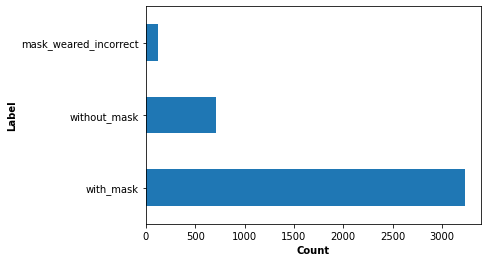

In [10]:
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

## Prepare the data


Sắp xếp lại dữ liệu vào các thử mục mới, dựa vào nhãn dán. Có 3 thư mục chính gồm (train/test/validation)

In [11]:
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)


Dựa vào mỗi ảnh gốc (có thể có nhiều gương mặt), cắt những gương mặt trong hình dựa vào tọa độ cho trước, và rồi copy chúng(gương mặt + nhãn của nó) vào thư mục mới.


In [12]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    
    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle 
     and returns a cropped image
    '''
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

func cắt gương mặt của mỗi người trong hình ảnh

In [13]:
def extract_faces(image_name, image_info):
    
    '''
     This function takes an image name + dataframe with information about the image 
     and splits the image into all the different faces. image name contains the 
     upper-left coordinate of each face so we could distinguish it later
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

We now apply the `extract_faces` function on our data set

In [14]:
cropped_faces = [extract_faces(img, df) for img in images]

Since the output of the `extract_faces` function is a list of lists, we need to flatten the cropped faces. i.e make it a list of images instead of a list of lists.


In [15]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_faces = sum(cropped_faces, [])
#flat_cropped_faces

Sắp xếp các ảnh (gương mặt) lại vào các lable(nhãn)

In [16]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

Kiếm tra lại số image xem quá trình cắt mặt gán lại lable có bị nhầm ở đâu k

In [17]:
print(f'num of images with mask: {len(with_mask)}')
print(f'num of images without mask: {len(without_mask)}')
print(f'num of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'sum: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

num of images with mask: 3231
num of images without mask: 715
num of images incorrect mask: 123
sum: 4069



Chia toàn bộ dữ liệu thành 2 tập train(80%) và test(20%). Trong tập test lại chia thành 2 tập nhỏ test(30%) và validation (70%)
Tập train: tập huấn luyện dữ liệu
Tập test: dùng để kiểm thực
Tập validation: tập kiểm chứng 

In [18]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [19]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     This function takes an image name + a path of output folder
     and saves image into the output folder
    '''

    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)   

Save lại các image vào các folder


In [20]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')


# Model Building - CNN

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 35, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0

2022-11-11 16:23:31.606962: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Vẽ model architecture

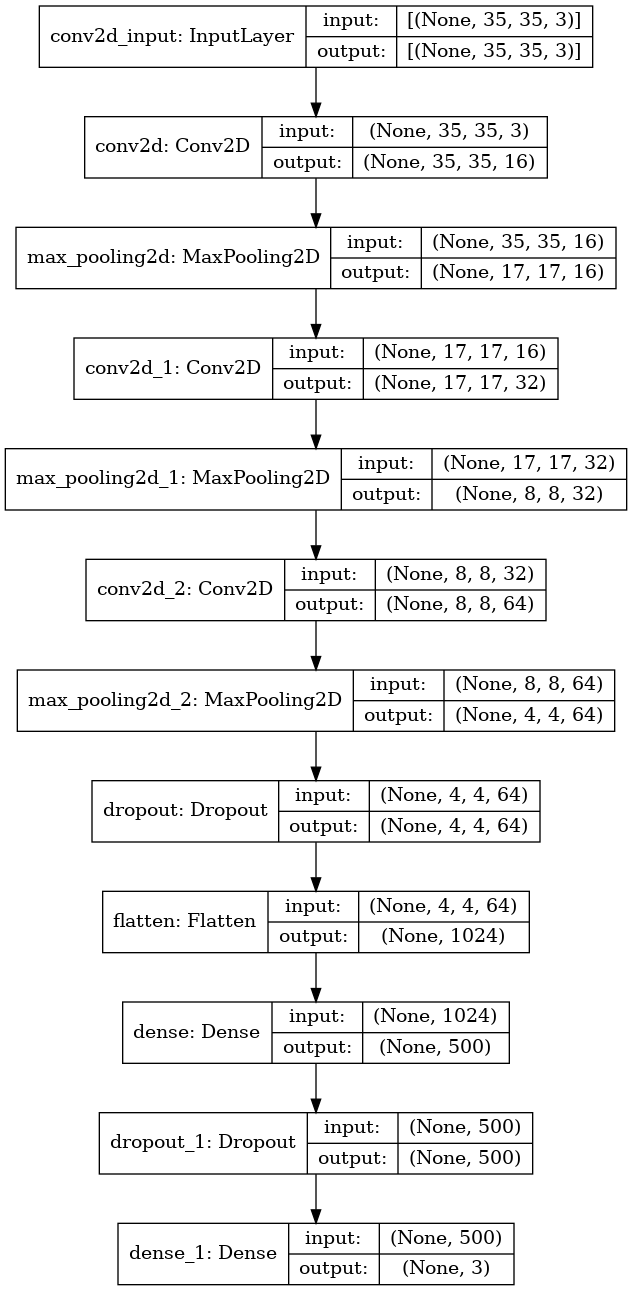

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

batch_size trong một lần lặp chọn ngẫu nhiên 8 ảnh chạy lan truyền trong mạng neural network, tiếp theo lại quăng ngẫu nhiên 8 ảnh cho đến khi hết ảnh -> đã hoàn thành 1 epochs


In [23]:
batch_size = 8
epochs = 50


Để tăng sự hiệu quả của mô hình. Ta sử dụng thêm một vài phương pháp tăng cường dữ liệu.
Sử dụng Keras `ImageDataGenerator` để tăng cường dữ liệu (scaling, rotating, flipping, etc.)
Tất nhiên lại bổ trường hợp xoay dọc (rất khó có khả năng gương mặt người lộn ngược @@)


In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='/kaggle/working/train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='/kaggle/working/val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='/kaggle/working/test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [25]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [26]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)
#model.optimizer.lr=0.001

## Early Stopping



In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

## Reduce Learning Rate On Plateau
We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric we chose (`val_loss`) has stopped improving.

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)


In [29]:
# Fit the model on train data

model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-11 16:23:34.479804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
50/50 [==============================] - 4s 44ms/step - loss: 0.5575 - accuracy: 0.8015 - recall: 0.7412 - precision: 0.8082 - auc: 0.9199 - val_loss: 0.5192 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8310 - val_auc: 0.9346
Epoch 2/50
50/50 [==============================] - 1s 20ms/step - loss: 0.4320 - accuracy: 0.8500 - recall: 0.8075 - precision: 0.8660 - auc: 0.9530 - val_loss: 0.1718 - val_accuracy: 0.9583 - val_recall: 0.9583 - val_precision: 0.9718 - val_auc: 0.9967
Epoch 3/50
50/50 [==============================] - 1s 20ms/step - loss: 0.2309 - accuracy: 0.9325 - recall: 0.9325 - precision: 0.9348 - auc: 0.9846 - val_loss: 0.2315 - val_accuracy: 0.9306 - val_recall: 0.9306 - val_precision: 0.9306 - val_auc: 0.9849
Epoch 4/50
50/50 [==============================] - 1s 21ms/step - loss: 0.2638 - accuracy: 0.9150 - recall: 0.9025 - precision: 0.9186 - auc: 0.9787 - val_loss: 0.2761 - val_accuracy: 0.8889 - val_recall: 0.8750 - val_precision: 0.887

In [30]:
# Evaluate model performance on test data
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (recall*100, precision*100, auc*100))

31/31 [==============================] - 0s 8ms/step - loss: 0.3116 - accuracy: 0.9177 - recall: 0.9095 - precision: 0.9247 - auc: 0.9689
Model has a loss of 0.31 and accuracy 91.77%
Model has a recall of 90.95%, precision of 92.47% and auc of 96.89%


In [31]:
predictions = model.predict(test_generator)
print("predictions shape:", predictions.shape)

predictions shape: (243, 3)


In [32]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')


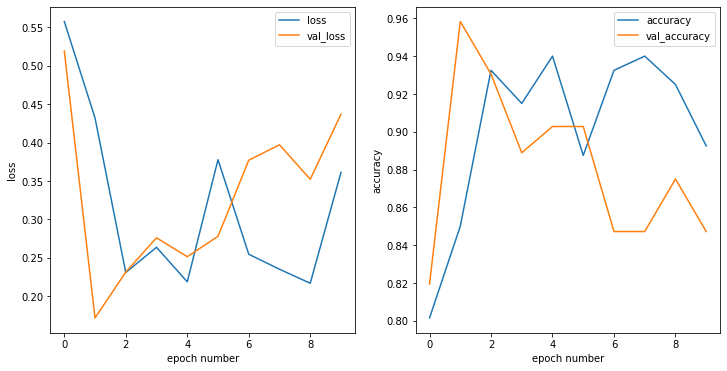

In [33]:
plot_loss_and_accuracy(model_history.history)

### Chọn ngẫu ngẫu nhiên một ảnh từ tập test và kiểm tra giữ lable gốc với lable dự đoán


Class Predicted: with_mask , True label: with_mask


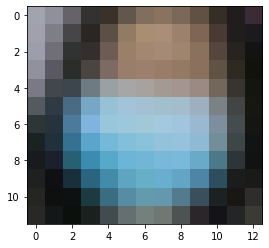

In [34]:
import cv2

paths = test_generator.filenames # Your files path

y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

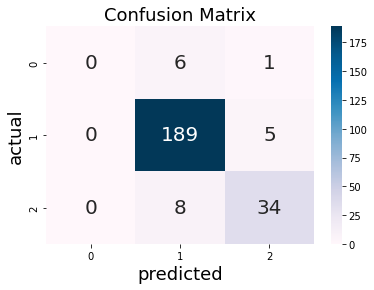

In [36]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [37]:
classes

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [38]:
np.bincount(y_pred) # Use bincount() to count occurrences of each class in a predictions NumPy array

array([  0, 203,  40])

# Testing the Results

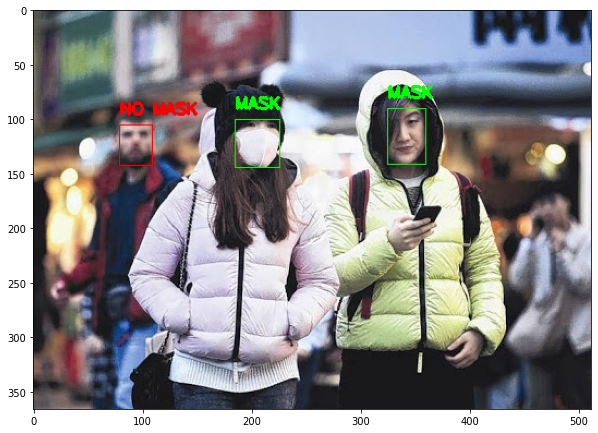

In [39]:
import cv2

img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)


In [40]:
print(final_test_image)

maksssksksss0


### Một vào hướng phát triển

Sử dụng một vài training pretrained model, chẳng hạn VGG19.
